# Outline: Representation and Selection of Descriptors
1. Description of typical descriptors and libraries for handling biomolecules
	a. Molecular fingerprints (e.g., ECFP, MACCS keys) 
	b. Learned representations (e.g., learned embeddings from molecular strings {SMILES, SELFIES, SMARTS patterns for structural fragments}, 2D graphs).
	c. Atomic-centered descriptors
		i. SOAP
	d. Coulomb matrices (where to put, exactly?)
	e. Physicochemical properties (e.g., molecular weight, logP, perhaps just go over the ones in QM7)

2. Typical data preprocessing steps
	a. Handling data on different scales (normalization and scaling techniques, standardization {e.g., z-score normalization}, min-max scaling, robust scaling 

3. Feature selection
	a.Illustrate with 2D representation, 3D representation, and MD trajectories (3 examples of increasing complexity).

# Description of typical descriptors and libraries for handling biomolecules 
Molecules are complex and can be represented by strings (e.g., SMILES), 2D graphs, and conformers. There are a few libraries for working with molecule "objects" in Python, one of the most popular being [RDKit](https://www.rdkit.org/), which we will also use in this notebook.

To import the necessary libraries for this tutorial, run the following cell:

In [1]:
from rdkit import Chem       # description
from rdkit.Chem import Draw  # used for drawing molecules
import numpy as np
import itertools
import scipy.io
import xyz2mol as xyz2mol
import ase.io

We can begin analyzing molecules by looking at the molecules in QM7. The QM7 dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules. It contains the Coulomb matrix representation of these molecules and their atomization energies computed similarly to the FHI-AIMS implementation of the Perdew-Burke-Ernzerhof hybrid functional (PBE0). This dataset features a large variety of molecular structures such as double and triple bonds, cycles, carboxy, cyanide, amide, alcohol and epoxy.

To download and load the QM7 dataset as a Python dictionary, run:

In [2]:
!wget http://quantum-machine.org/data/qm7.mat
!mv qm7.mat ../data/.

raw_qm7 = scipy.io.loadmat("../data/qm7.mat") # the qm7 dataset will be loaded as a Python dictionary

--2023-07-06 16:24:35--  http://quantum-machine.org/data/qm7.mat
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17884280 (17M)
Saving to: ‘qm7.mat’

qm7.mat             100%[===================>]  17,06M  16,7MB/s    in 1,0s    

2023-07-06 16:24:37 (16,7 MB/s) - ‘qm7.mat’ saved [17884280/17884280]



The dataset is composed of five multidimensional arrays:
- X (7165 x 23 x 23) - Coulomb matrices
- T (7165) - atomization energies (the labels)
- P (5 x 1433) - cross-validation splits
- Z (7165) - atomic charge of each atom in the molecules
- R (7165 x 3) - Cartesian coordinates of each atom in the molecules

In [4]:
X = raw_qm7["X"]
T = raw_qm7["T"]
P = raw_qm7["P"]
Z = raw_qm7["Z"]
R = raw_qm7["R"]

To make it a bit easier to work with the molecules, let's convert them into RDKit ´Mol´ objects, and respectively into the corresponding SMILES:

In [14]:
# Get the molobjs
atoms       = Z
coordinates = R

mols   = []
smiles = []
for idx, atom in enumerate(atoms):
    mol = xyz2mol.xyz2mol(atom, coordinates[idx], allow_charged_fragments=False)
    mols.append(mol)
    smiles.append(Chem.MolToSmiles(mol))


Let's look at some of the SMILES. The first corresponds to methane, then ethane, then ethene:

In [22]:
print("methane:", smiles[0])  # assert that the SMILES match the correct one?
print("ethane:", smiles[1])
print("ethene:", smiles[2])

methane: [C].[H].[H].[H].[H]
ethane: [C].[C].[H].[H].[H].[H].[H].[H]
ethene: [C].[C].[H].[H].[H].[H]


## Molecular Fingerprints
Now that we have our list of molecules, we can represent them using one of the most common representations used in cheminformatics: [Morgan fingerprints](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf). Fingerprints can have different, user-defined lengths. Here, we will generate radius 2 Morgan fingerprints for the above three molecules using bit lengths of 256, 512, and 1048:

In [32]:
# 256-bit
methane_256fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[0], useChirality=True, radius=2, nBits=256)
ethane_256fp  = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[1], useChirality=True, radius=2, nBits=256)
ethene_256fp  = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[2], useChirality=True, radius=2, nBits=256)
 
# 512-bit
methane_512fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[0], useChirality=True, radius=2, nBits=512)
ethane_512fp  = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[1], useChirality=True, radius=2, nBits=512)
ethene_512fp  = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[2], useChirality=True, radius=2, nBits=512)

# 1048-bit
methane_1048fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[0], useChirality=True, radius=2, nBits=1048)
ethane_1048fp  = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[1], useChirality=True, radius=2, nBits=1048)
ethene_1048fp  = Chem.AllChem.GetMorganFingerprintAsBitVect(mols[2], useChirality=True, radius=2, nBits=1048)

Let's visualize the different fingerprints as heat maps:

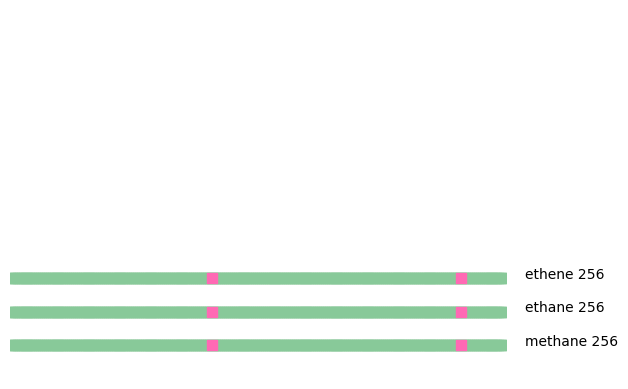

In [73]:
methane = np.array(methane_256fp)
ethane  = np.array(ethane_256fp)
ethene  = np.array(ethene_256fp)

import matplotlib.pyplot as plt

def plot_fingerprint():
    


## methane
# let's plot the zero bits in green 
methane_256_zero_bits = np.where(methane == 0.0)[0]
methane_256_x = methane_256_zero_bits #methane_256fp[methane_256_zero_bits]
methane_256_y = methane[methane_256_zero_bits] * 0 + 0 
plt.scatter(methane_256_x, methane_256_y, color="#88c999", s=50, marker="s")

# let's plot the non-zero bits in hot pink
methane_256_nonzero_bits = np.where(methane != 0.0)[0]
methane_256_x = methane_256_nonzero_bits #methane_256fp[methane_256_zero_bits]
methane_256_y = methane[methane_256_nonzero_bits] * 0 + 0
plt.scatter(methane_256_x, methane_256_y, color="hotpink", s=50, marker="s")

## ethane
# let's plot the zero bits in green 
ethane_256_zero_bits = np.where(ethane == 0.0)[0]
ethane_256_x = ethane_256_zero_bits #ethane_256fp[ethane_256_zero_bits]
ethane_256_y = ethane[ethane_256_zero_bits] * 0 + 1 
plt.scatter(ethane_256_x, ethane_256_y, color="#88c999", s=50, marker="s")

# let's plot the non-zero bits in hot pink
ethane_256_nonzero_bits = np.where(ethane != 0.0)[0]
ethane_256_x = ethane_256_nonzero_bits #ethane_256fp[ethane_256_zero_bits]
ethane_256_y = ethane[ethane_256_nonzero_bits] * 0 + 1
plt.scatter(ethane_256_x, ethane_256_y, color="hotpink", s=50, marker="s")

## ethene
# let's plot the zero bits in green 
ethene_256_zero_bits = np.where(ethene == 0.0)[0]
ethene_256_x = ethene_256_zero_bits #ethene_256fp[ethene_256_zero_bits]
ethene_256_y = ethene[ethene_256_zero_bits] * 0 + 2 
plt.scatter(ethene_256_x, ethene_256_y, color="#88c999", s=50, marker="s")

# let's plot the non-zero bits in hot pink
ethene_256_nonzero_bits = np.where(ethene != 0.0)[0]
ethene_256_x = ethene_256_nonzero_bits #ethene_256fp[ethene_256_zero_bits]
ethene_256_y = ethene[ethene_256_nonzero_bits] * 0 + 2
plt.scatter(ethene_256_x, ethene_256_y, color="hotpink", s=50, marker="s")

# add a label
plt.text(256 + 10, 0, "methane 256")
plt.text(256 + 10, 1, "ethane 256")
plt.text(256 + 10, 2, "ethene 256")

plt.xlim([0, 256])
plt.ylim([-1, 10])
plt.axis("off")

plt.show()

In [7]:
smiles = Chem.MolToSmiles(mol=mols[0])

In [8]:
smiles

'[C].[H].[H].[H].[H]'

[16:24:49] unsupported number of radical electrons 4


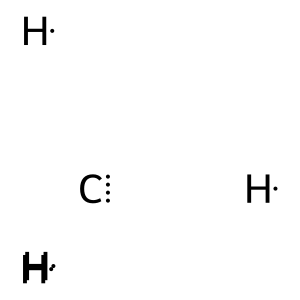

In [9]:
img = Draw.MolToImage(mols[0])
img




In [10]:
print(mol_0)
Chem.rdmolfiles.MolToSmiles(mol_0)


NameError: name 'mol_0' is not defined

## Molecular fingerprints